# Crime Data from New York State in 2013

For this exercise, we will examine [crime data in New York State](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls), made avaiable by the FBI. The goal of the exercise is to build a multivariable regression model to predict property crimes. 

We will ultimately specify the model as: 

Propertycrime=α+Population+Population2+Murder+Robbery

We'll start by setting up the notebook and reading in the data, trimming header and footer rows from the original data file.

In [111]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import seaborn as sns
import scipy.stats as stats
sns.set_style("whitegrid")

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#Read in the data, removing rows with metadata and footnotes.
crime = pd.read_excel('/Users/teresaoneill/Dropbox/Thinkful/Datasets/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', skiprows=4, skip_footer=3)
print(len(crime))
crime.head()

348


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


In [112]:
crime.columns=['city', 'population','violent_crime', 'murder', 'rape1', 'rape2', 'robbery','agg_assault','property_crime','burlary','larceny','vehicle','arson']
#Take the subset of relevant numeric columns.
crime_sub = pd.concat([crime['population'], crime['murder'], crime['robbery'], crime['property_crime']], axis=1)

First, let's take a look at the data, to identify and clean any anomalous values. Let's begin with any missing data, to look for patterns. Then we'll inspect the distribution of each of our relevant variables.

In [113]:
#Check for nulls.
for col in crime_sub.columns:
    print(crime_sub[pd.isnull(crime_sub[col])])

Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []
Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []
Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []
Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []


It appears that there are no missing values, so let's proceed to the summary statistics and some basic visualizations.

count       348.000
mean      40037.632
std      450037.368
min         526.000
25%        3003.000
50%        7233.500
75%       18427.500
max     8396126.000
Name: population, dtype: float64
count   348.000
mean      1.566
std      18.304
min       0.000
25%       0.000
50%       0.000
75%       0.000
max     335.000
Name: murder, dtype: float64
count     348.000
mean       72.902
std      1031.033
min         0.000
25%         0.000
50%         1.000
75%         5.000
max     19170.000
Name: robbery, dtype: float64
count      348.000
mean       792.606
std       7659.725
min          0.000
25%         40.500
50%        112.500
75%        341.000
max     141971.000
Name: property_crime, dtype: float64


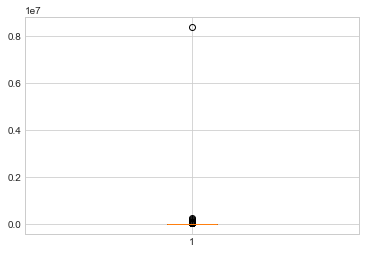

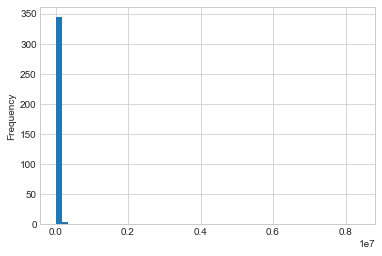

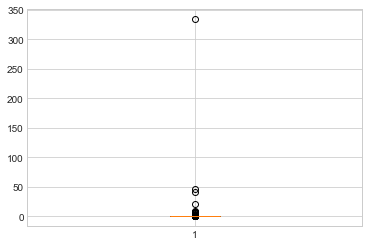

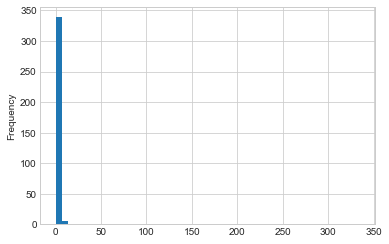

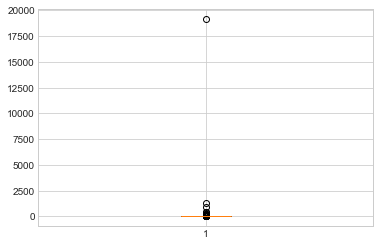

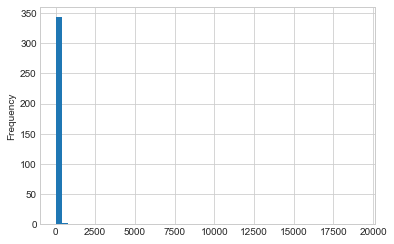

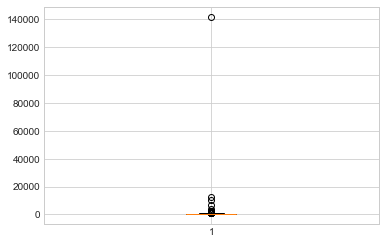

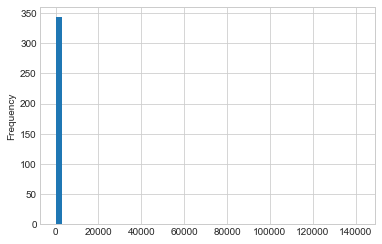

In [114]:
#Generate descriptions for each column.

for col in crime_sub.columns:
    print(crime_sub[col].describe())

#Look at the distributions of each with a boxplot and a histogram.

plt.boxplot(crime_sub['population'])
plt.show()

crime_sub['population'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['murder'])
plt.show()
crime_sub['murder'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['robbery'])
plt.show()
crime_sub['robbery'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['property_crime'])
plt.show()
crime_sub['property_crime'].plot(kind='hist', bins=50)
plt.show()

These variables are not looking very normal! It appears that we have very densely clustered values at the low end of the range, with a few exteme outliers skewing everything. In fact, for the crime variables, there are quite a few zeros: at least 75% of cities have no murders and at least 25% of cities have no robberies. Ultimately, these two variables will be converted to binary categories, to better capture the distribution. For the sake of practice, however, and to prepare the population and property crimes variables for modeling, let's implement a strategy for dealing with outliers for the sake of practice.

Something we know about this dataset is that New York state includes New York City, the most populous city in the country by far, so we expect the extreme outlier values we find here. To deal with outliers (and any others), let's winsorize the data, assigning all values above the 95th percentile to the 95th percentile. We'll vizualize the variables again after winsorizing, paying particular attention to the dependent variable, property crimes. 

count     348.000
mean    13620.954
std     15232.629
min      1350.000
25%      3003.000
50%      7233.500
75%     18427.500
max     57559.000
Name: population, dtype: float64
count   348.000
mean      0.193
std       0.510
min       0.000
25%       0.000
50%       0.000
75%       0.000
max       2.000
Name: murder, dtype: float64
count   348.000
mean      6.917
std      14.534
min       0.000
25%       0.000
50%       1.000
75%       5.000
max      60.000
Name: robbery, dtype: float64
count    348.000
mean     280.491
std      376.367
min        8.000
25%       40.500
50%      112.500
75%      341.000
max     1391.000
Name: property_crime, dtype: float64


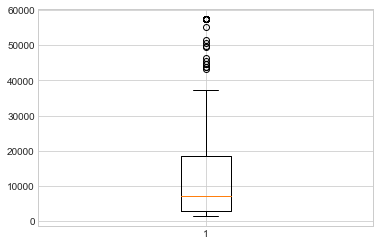

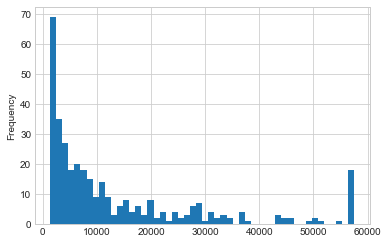

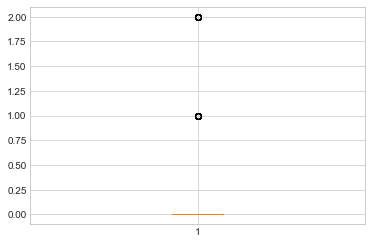

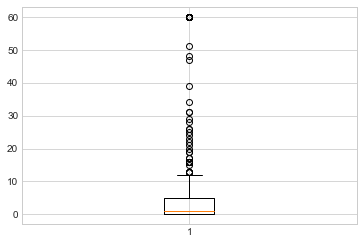

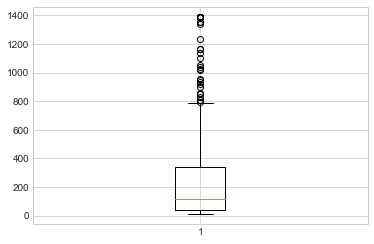

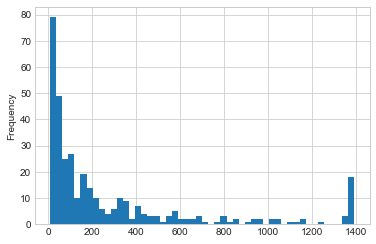

In [115]:
#Winsorize and take another look.
for col in crime_sub.columns:
    stats.mstats.winsorize(crime_sub[col], limits=0.05, inplace=True),
    print(crime_sub[col].describe())

plt.boxplot(crime_sub['population'])
plt.show()
crime_sub['population'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['murder'])
plt.show()

plt.boxplot(crime_sub['robbery'])
plt.show()

plt.boxplot(crime_sub['property_crime'])
plt.show()

crime_sub['property_crime'].plot(kind='hist', bins=50)
plt.show()

The dependent variable will now be easier to work with, as it has more of a lognormal distribution, much like population. Let's take a quick look at the relationships between the variables before we recode robbery and murder as categorical. 

According to the plots and correlation matrix below, there is a strong linear relationship between population and property crimes, which is not surprizing. There is also a linear relationship between some of our input variables, which could lead to multicollinearity violation. Below, we'll do some recoding that will suit the model better.

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


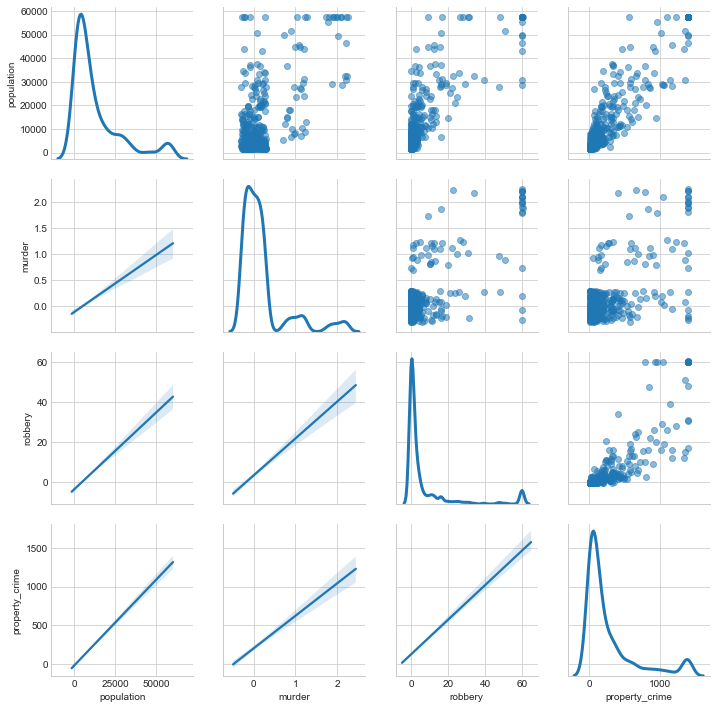

                population  murder  robbery  property_crime
population           1.000   0.625    0.801           0.896
murder               0.625   1.000    0.720           0.627
robbery              0.801   0.720    1.000           0.861
property_crime       0.896   0.627    0.861           1.000


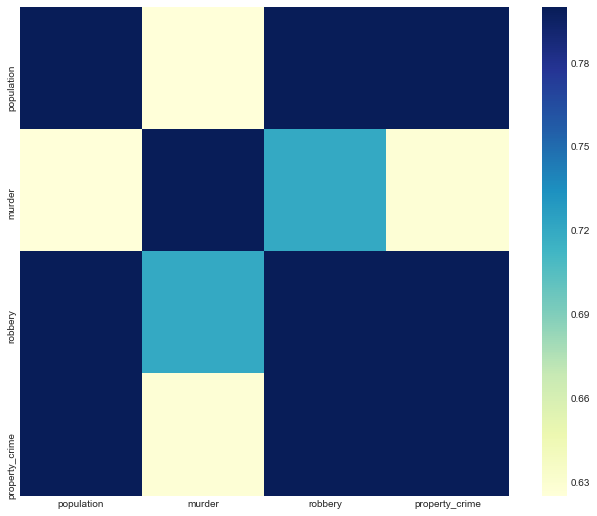

In [116]:
crime_jittered = crime_sub.loc[:, 'population':].dropna()

# Make the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(crime_jittered.shape)),
    columns=crime_jittered.columns
)

# Combine the data and the noise.

crime_jittered = crime_jittered.add(jitter)
#Declare the plot and plot.
g = sns.PairGrid(crime_jittered.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

# Take a look at the correlation matrix and visualize with a heatmap.

corrmat = crime_sub.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

For this model, robbery and murder will be recoded as binary categorical features. Let's recode them now, and take a look at the numer of observations in each level.

In [117]:
crime_sub['robbery'] = np.where(crime_sub['robbery']>0, 1, 0)
crime_sub['murder'] = np.where(crime_sub['murder']>0, 1, 0)

print(crime_sub['robbery'].value_counts())
print(crime_sub['murder'].value_counts())

1    209
0    139
Name: robbery, dtype: int64
0    299
1     49
Name: murder, dtype: int64


We're now ready to start modeling. 